# Baneproblemet

I denne demonstrasjonen ser vi på en kule med masse $m$ som følger en gitt bane $y = f(x)$ i tid fra $x = -L/2$ til $x = L/2$. Energien til kulen er bevart:
$$ E = \frac{1}{2} m v^2 + m g y = \frac{1}{2} m v_0^2 $$
der $v_0$ er kulens initielle fart. Når vi løser for $v$ ser vi at $m$ faller ut av likningene, slik farten er gitt ved
$$ v = \sqrt{ v_0^2 - 2 g y} .$$

Vi ønsker nå å finne uttrykket for tiden $T$ ballen bruker på å komme seg fra $x = -L/2$ til $x = L/2$. Vi skriver ned differensialet
$$ \frac{ds}{dt} = v \quad \text{der} \quad ds = \sqrt{dx^2 + dy^2} = \sqrt{ 1 + (f'(x))^2 } dx .$$
Vi reorganiserer og integrerer:
$$ t (x) = \int_0^t d\bar t = \int \frac{ds}{v} = \int_{-L/2}^x \sqrt{\frac{1 + f'(\bar x)^2}{v_0^2 - 2 g f(\bar x)}} d \bar x .$$
Dette integralet må beregnes numerisk for en gitt funksjon $f$.
Spesifikt er $T = t(L/2)$.

I dette problemet inngår
* Gravitasjonsakselerasjonen $g = 9.81 \, \text{m s}^{-2}$
* Initiell fart $v_0$

For å beskrive "rampefunksjonen" $f(x)$ trenger vi:
* Lengden av rampen $L$.
* Lengden av dippen $\ell$
* Amplituden til dippen $a$
* En lengdeskala for hvor fort dippen dipper $\epsilon$

In [1]:
# Definerer konstanter som ikke vil endre seg
g = 9.81  # gravitasjonsakselerasjon [m/s^2]
L = 2.0   # lengde av banen [m]
l = 1.0   # lengde av dippen [m]
eps = 0.05 # overgang av dippen [m]

For å modellere banen på en glatt måte bruker vi en S-formet (_sigmoid_) funksjon som $\tanh$-funksjonen:
$$ \tanh x = \frac{e^x - e^{-x}}{e^x + e^{-x}} .$$
Den ser slik ut:

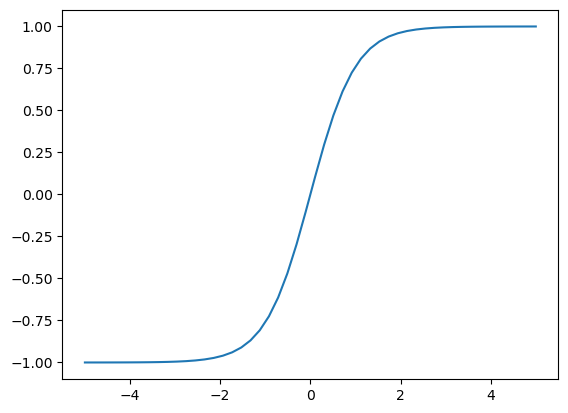

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5)
fig, ax = plt.subplots(1, 1)
ax.plot(x, np.tanh(x))

Vi kan konstruere en rampefunksjon med dybde $a$ ved å bruke to slike:
$$ f(x) = a \left[ \tanh \left( \frac{x - l/2}{\epsilon} \right) - \tanh \left( \frac{x + l/2}{\epsilon} \right) \right] $$

Vi bruker `sympy` for å lage et symbolsk uttrykk som vi kan derivere. Vi plotter også formen på banen for ulike $a$:

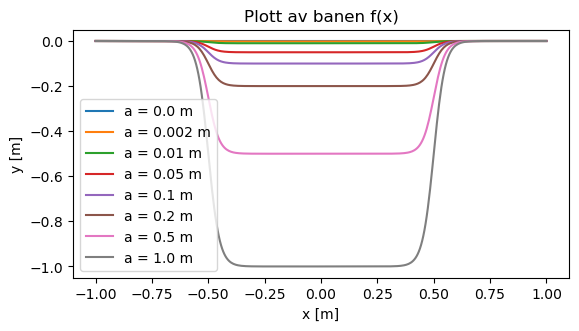

In [3]:
import sympy as sp

# Definer symbolene
x, v0, a = sp.symbols('x v0 a')
y = a * (sp.tanh((x - l / 2) / eps) - sp.tanh((x + l / 2) / eps))/2
#y = -a * (L/2 - x) * (L/2 + x) / (L**2 / 4)  # parabolsk dipp

x_vals = np.linspace(-L/2, L/2, 400)

fig, ax = plt.subplots()
ax.set_title('Plott av banen f(x)')
ax.set_aspect("equal")

# plott y med a = 0.1
# Gjør y om til en numerisk funksjon
y_func = sp.lambdify((x, a), y, 'numpy')

a_vals = [0., 0.002, 0.01, 0.05, 0.1, 0.2, 0.5, 1.]   # dippamplituder [m]

for a_value in a_vals:
    y_vals = y_func(x_vals, a_value)
    ax.plot(x_vals, y_vals, label=f'a = {a_value} m')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()

Vi lager funksjoner for å beregne integralene over numerisk.

In [4]:
# Beregn den første deriverte
dydx = sp.diff(y, x)

# Beregn sqrt( 1 + y'^2 ) der y' er den første deriverte
sqrt_expr = sp.sqrt(1 + dydx**2)
v_expr = sp.sqrt(v0**2 - 2*g*y)

integrand_expr = sqrt_expr / v_expr

# gjør integrand_expr om til en numerisk funksjon
integrand_expr_func = sp.lambdify((x, v0, a), integrand_expr, 'numpy')

# integrer fra -L/2 til L/2 numerisk
from scipy.integrate import quad

# Funksjonen t(x)
def compute_time(v0_val, a_val, x):
    result, error = quad(integrand_expr_func, -L/2, x, args=(v0_val, a_val))
    return result

# total tid T = t(L/2)
def compute_time_of_flight(v0_val, a_val):
    return compute_time(v0_val, a_val, L/2)

Vi beregner og plotter oppførselen $t (x)$ for ulike verdier av $v_0, a$ og ser at størrelsen på $a$ har mye å si for hvor lang tid det tar. For $a=0$ følger ballen en rett linje i $tx$-diagrammet, altså har den konstant hastighet.

I tillegg plotter vi en enkel teoretisk approksimasjon som vi skal undersøke nedenfor.

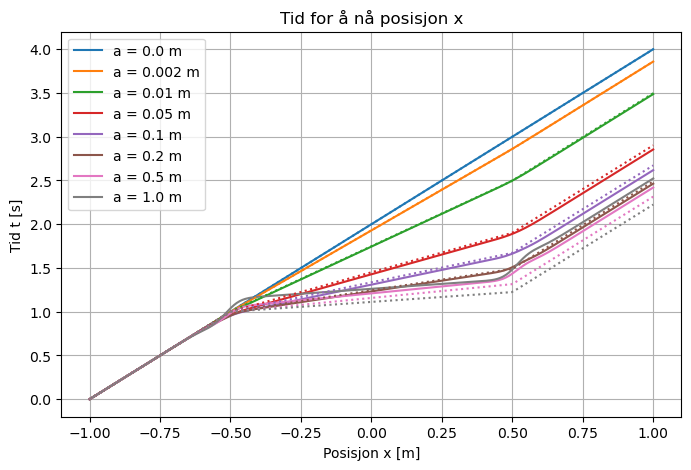

In [5]:
v0_val = 0.5  # initiell fart [m/s]

x_ = np.linspace(-L/2, L/2, 200)
t_ = [np.array([compute_time(v0_val, a_val, x) for x in x_]) for a_val in a_vals]

# Plott t(x) for forskjellige a-verdier
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, a_val in enumerate(a_vals):
    ax.plot(x_, t_[i], label=f"a = {a_val} m")

# Vi plotter også en enkel teoretisk modell for t(x)
# Anta at fartsendringen skjer momentant ved -l/2 og l/2
v1_vals = np.sqrt(v0_val**2 + 2*g*np.array(a_vals))
for i, v1_val in enumerate(v1_vals):
    t_th_ = (x_ + L/2)/v0_val 
    t_th_[x_ > -l/2] = (L/2 - l/2)/v0_val + (x_[x_ > -l/2] + l/2)/v1_val
    t_th_[x_ > l/2] = (L/2 - l/2)/v0_val + l/v1_val + (x_[x_ > l/2] - l/2)/v0_val
    # plott med samme farge som numerisk løsning
    ax.plot(x_, t_th_, color=ax.get_lines()[i].get_color(), linestyle='dotted')

ax.set_title('Tid for å nå posisjon x')
ax.set_xlabel('Posisjon x [m]')
ax.set_ylabel('Tid t [s]')
ax.grid()
ax.legend()


Nå ønsker vi å beregne normalkraften fra banen. Vi begynner med å beregne akselerasjonen numerisk komponentvis.

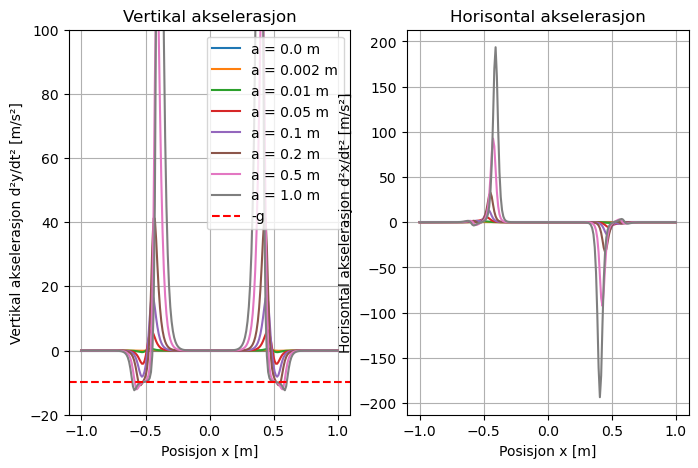

In [6]:

from scipy.interpolate import InterpolatedUnivariateSpline

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ay_ = [None for _ in a_vals]
ax_ = [None for _ in a_vals]

# Beregn akselerasjoner d²y/dt² og d²x/dt²
# Først, beregn y(x) for hver a
# Deretter, lag en interpolerende spline av y(t) og x(t)
# Til slutt, beregn den andrederiverte av splinene mhp tid

y_ = y_func(x_, a_val)
for i, a_val in enumerate(a_vals):
    y_ = y_func(x_, a_val)
    y_intp = InterpolatedUnivariateSpline(t_[i], y_)
    x_intp = InterpolatedUnivariateSpline(t_[i], x_)
    ay_[i] = y_intp.derivative(2)(t_[i])
    ax_[i] = x_intp.derivative(2)(t_[i])

    ax[0].plot(x_, ay_[i], label=f"a = {a_val} m")
    ax[1].plot(x_, ax_[i], label=f"a = {a_val} m")

ax[0].axhline(-g, color='r', linestyle='--', label='-g')
ax[0].legend()
ax[0].set_ylim(-20, 100)
ax[0].set_title('Vertikal akselerasjon')
ax[0].set_xlabel('Posisjon x [m]')
ax[0].set_ylabel('Vertikal akselerasjon d²y/dt² [m/s²]')
ax[0].grid()
ax[1].set_title('Horisontal akselerasjon')
ax[1].set_xlabel('Posisjon x [m]')
ax[1].set_ylabel('Horisontal akselerasjon d²x/dt² [m/s²]')
ax[1].grid()
plt.show()

#T = compute_time_of_flight(v0_val, a_val)
#print(f"Total time of flight: {T:.4f} s")

Vi ser at for tilstrekkelig høy amplitude $a$ vil akselerasjonen bli lavere enn $-g$! Dette betyr at om ballen sklir *på* en bane ville den her ha lettet og resten av banen er ikke gyldig. I dette tilfellet må vi derfor anta at ballen er tredd på en friksjonsløs stang (som en kuleramme).

For å beregne normalkraften fra banen bruker vi normalvektoren til banen, $\hat{\bf n}$:
$$ \hat{\bf n} = \frac{- f'(x) \hat{\bf x} + \hat{\bf y}}{\sqrt{1 + f'(x)^2}} $$
slik at
$$ F_n = \hat{\bf n} \cdot \bf F $$
der Newtons andre lov gir
$$ \bf F - m g \hat{\bf n} = m \bf a .$$

Der $F_n < 0$ vil kulen på en bane slippe taket og vi får fritt fall (som vi ikke løser her). Vi ser at dette skjer ved tilstrekkelig høy $a$.

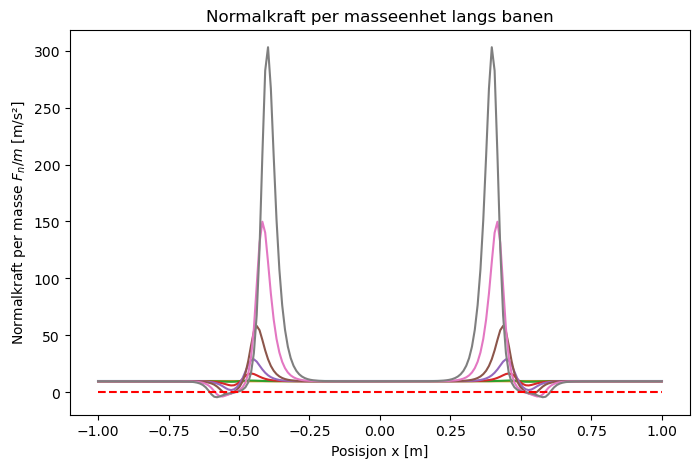

In [7]:
ny = 1 / sp.sqrt(1 + dydx**2)
nx = - dydx / sp.sqrt(1 + dydx**2)
nx_func = sp.lambdify((x, a), nx, 'numpy')
ny_func = sp.lambdify((x, a), ny, 'numpy')

fx_ = [ax_[i] for i in range(len(a_vals))]
fy_ = [ay_[i] + g for i in range(len(a_vals))]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, a_val in enumerate(a_vals):
    fn_ = fx_[i] * nx_func(x_, a_val) + fy_[i] * ny_func(x_, a_val)
    ax.plot(x_, fn_, label=f"a = {a_val} m")
ax.set_title('Normalkraft per masseenhet langs banen')
ax.set_xlabel('Posisjon x [m]')
ax.set_ylabel('Normalkraft per masse $F_n/m$ [m/s²]')
ax.hlines(0, -L/2, L/2, colors='r', linestyles='--', label='$F_n = 0$')

Nå vil vi plotte $T$ som funksjon av $a$. Vi løser derfor numerisk $T = t(l/2)$ for ulike $a$ og plotter det.

I tillegg kan vi lage en enkel modell for kurven og sammenlikne. Vi antar at ballen følger hastigheten $v_0$ over en avstand $L-\ell$. I tillegg følger den hastigheten $v_1 = \sqrt{v_0^2 + 2 g a}$ over en avstand $\ell$.
Dette gir
$$ T \approx \frac{L-\ell}{v_0} + \frac{\ell}{v_1} = \frac{L}{v_0} \left[ \frac{L-\ell}{L} + \frac{\ell}{L \sqrt{1 + \frac{2 g a}{v_0^2}}} \right]$$

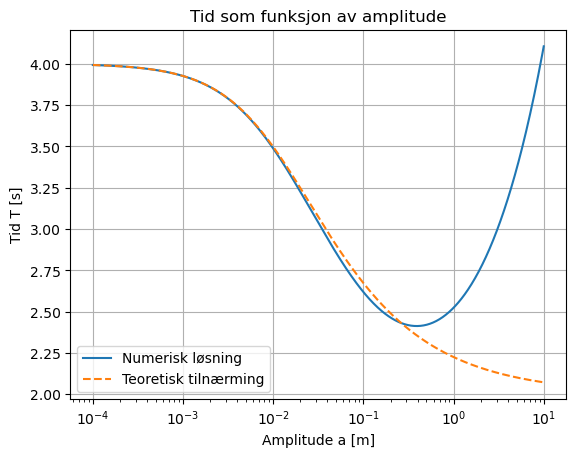

In [8]:
# gjør en skanning over a_val
a_vals = np.logspace(-4, 1, 1000)
T_vals = np.array([compute_time_of_flight(v0_val, a) for a in a_vals])

T_th = L / v0_val * ( (L-l)/L + l/L / np.sqrt(1 + (2*g*a_vals)/(v0_val**2)) )

fig, ax = plt.subplots()
ax.plot(a_vals, T_vals, label='Numerisk løsning')
ax.plot(a_vals, T_th, linestyle='--', label='Teoretisk tilnærming')
ax.legend()

ax.set_title('Tid som funksjon av amplitude')
ax.set_xlabel('Amplitude a [m]')
ax.set_ylabel('Tid T [s]')
ax.grid()
ax.semilogx()
plt.show()

Vi ser at den numeriske løsningen når et minimum for en gitt amplitude $a$.
Vi ser at den numeriske løsningen og den teoretiske tilnærmingen stemmer godt overens for små $a$, men avviker for store $a$.
Dette er fordi den teoretiske tilnærmingen ikke tar høyde for at kulen kan bremses midlertidig av å tvinges til å følge rampen.